**Описание проекта**

Вы работаете в стартапе, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи вашего мобильного приложения.

Изучите воронку продаж. Узнайте, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?

После этого исследуйте результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясните, какой шрифт лучше.

Создание двух групп A вместо одной имеет определённые преимущества. Если две контрольные группы окажутся равны, вы можете быть уверены в точности проведенного тестирования. Если же между значениями A и A будут существенные различия, это поможет обнаружить факторы, которые привели к искажению результатов. Сравнение контрольных групп также помогает понять, сколько времени и данных потребуется для дальнейших тестов.

**Описание данных**

Каждая запись в логе — это действие пользователя, или событие.
- `EventName` — название события;
- `DeviceIDHash` — уникальный идентификатор пользователя;
- `EventTimestamp` — время события;
- `ExpId` — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

## Подготовка к анализу данных

In [49]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import scipy.stats as st
from matplotlib.pyplot import figure

In [50]:
df = pd.read_csv(r'C:\Users\564\Downloads\logs_exp.csv', sep='\t')

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [51]:
# поиск явных дубликатов
df.duplicated().sum()

413

In [52]:
# удаление явных дубликатов
df = df.drop_duplicates().reset_index(drop=True)
df.duplicated().sum()

0

In [53]:
# меняем названия столбцов
df.columns = ['event', 'user_id', 'timestamp', 'exp_id']

In [54]:
# меняем тип данных столбца timestamp на datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')

# добавляем столбец с датами
df['date'] = df['timestamp'].apply(lambda x:x.date())

In [55]:
df.head()

,event,user_id,timestamp,exp_id,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


**Вывод:**

Пропусков в данных не обнаружено, дубликаты удалены, тип данных столбца timestamp скорректирован

## Изучение и проверка данных

### Количество событий в логе

In [56]:
number_of_events = df['event'].count()
print('событий в логе:', number_of_events)

событий в логе: 243713


### Количество пользователей в логе

In [57]:
number_of_users = df['user_id'].nunique()
print('пользователей в логе:', number_of_users)

пользователей в логе: 7551


### Количество событий на пользователя

In [58]:
print('событий на пользователя:', df['event'].count()/df['user_id'].nunique())

событий на пользователя: 32.27559263673685


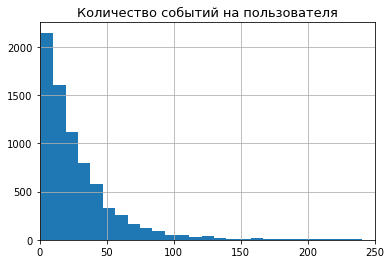

In [59]:
histogram = df.groupby('user_id')['event'].count().hist(bins=250)
histogram.set_xlim([0, 250])
plt.title('Количество событий на пользователя', fontsize=13)
plt.show()

### Изучим временной период

In [60]:
print('минимальная дата:', df['date'].min())
print('максимальная дата:', df['date'].max())

минимальная дата: 2019-07-25
максимальная дата: 2019-08-07


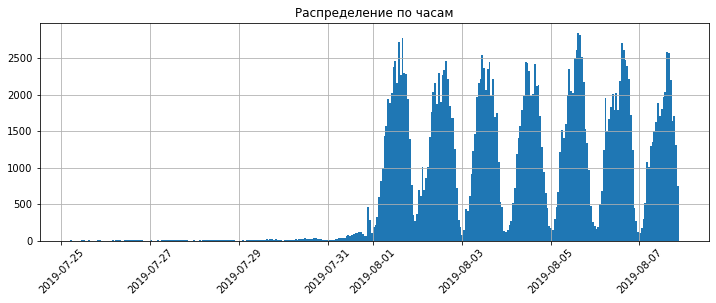

In [61]:
df['timestamp'].hist(bins=336, figsize=(12,4))
plt.title('Распределение по часам')
plt.xticks(rotation=45)
plt.show()

Полные данные появляются только с 2019-07-31 17:00:00, данные за более ранние даты придется отбросить

In [62]:
df = df[df['timestamp'] >= '2019-07-31 17:00:00']
df['date'].nunique()

8

**Вывод:**

Располагаем данными за 7 с половиной дней

### Количество отброшенных событий и пользователей

In [63]:
print('потеряно событий:', '{:.1%}'.format((number_of_events - df['event'].count()) / df['event'].count()))

потеряно событий: 0.7%


In [64]:
print('потеряно пользователей:',
'{:.1%}'.format((number_of_users - df['user_id'].nunique()) / df['user_id'].nunique()))

потеряно пользователей: 0.1%


### Проверим наличие пользователей из всех трёх экспериментальных групп

In [65]:
df.groupby('exp_id')['user_id'].nunique()

exp_id
246    2485
247    2517
248    2539
Name: user_id, dtype: int64

246 и 247 — контрольные группы, а 248 — экспериментальная

## Изучим воронку событий

### Посмотрим, какие события есть в логах и как часто они встречаются

In [66]:
df.groupby('event')['event'].count().sort_values(ascending=False)

event
MainScreenAppear           118064
OffersScreenAppear          46590
CartScreenAppear            42410
PaymentScreenSuccessful     33990
Tutorial                     1010
Name: event, dtype: int64

### Посчитаем долю пользователей, которые хоть раз совершали определенное действие

In [67]:
(df.groupby('event')['user_id'].nunique().sort_values(ascending=False)
/ df['user_id'].nunique()*100).round(1).astype(str) + '%'

event
MainScreenAppear           98.5%
OffersScreenAppear         61.0%
CartScreenAppear           49.6%
PaymentScreenSuccessful    46.9%
Tutorial                   11.2%
Name: user_id, dtype: object

Можно предположить, что в большинстве случаев события происходят последовательно, начиная с просмотра главной страницы и заканчивая оплатой товара. Событие Tutorial, судя по количеству, не обязательно для совершения покупки или других действий на сайте. Возможно, на сайте есть способ совершать покупки минуя и другие этапы.

### Построим воронку событий и посчитаем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем)

In [68]:
funnel = df.query('event != "Tutorial"').groupby('event').agg({'event': 'first', 'user_id': 'nunique'}).sort_values('user_id', ascending=False).reset_index(drop=True)

fig = go.Figure(go.Funnel(
    y = funnel['event'],
    x = funnel['user_id'],
    textposition = "inside",
    textinfo = "value+percent previous"))
fig.show()

**Выводы:**

- Судя по воронке событий, больше всего пользователей уходят с сайта после просмотра главной страницы
- От просмотра главной страницы до оплаты доходят 47.7% пользователей

## Изучим результаты эксперимента

### Количество пользователей в контрольных и экспериментальной группах

In [69]:
df.groupby('exp_id').agg({'user_id': 'nunique'})

,user_id
exp_id,
246,2485
247,2517
248,2539


Сравним количество пользователей в контрольных группах (246 и 247)

In [70]:
print('{:.1%}'.format(1 - df[df['exp_id'] == 246]['user_id'].nunique() 
                      / df[df['exp_id'] == 247]['user_id'].nunique()))

1.3%


Сравним количество пользователей в группах 246 и 248

In [71]:
print('{:.1%}'.format(1 - df[df['exp_id'] == 246]['user_id'].nunique() 
                      / df[df['exp_id'] == 248]['user_id'].nunique()))

2.1%


Сравним количество пользователей в группах 247 и 248

In [72]:
print('{:.1%}'.format(1 - df[df['exp_id'] == 247]['user_id'].nunique() 
                      / df[df['exp_id'] == 248]['user_id'].nunique()))

0.9%


**Вывод:**

Группы набирались не совсем оптимально, но это не помешает провести проверку гипотез

### Проверим группы на наличие общих пользователей (пересечений)

In [73]:
A1 = list(df.query('exp_id == 246')['user_id'].unique())
A2 = list(df.query('exp_id == 247')['user_id'].unique())

df.query('exp_id == 246').query('user_id in @A2')['user_id'].count()

0

In [74]:
df.query('exp_id == 248').query('user_id in @A1')['user_id'].count()

0

In [75]:
df.query('exp_id == 248').query('user_id in @A2')['user_id'].count()

0

**Вывод:**

Пересечений пользователей в группах не найдено

### Проверим, является ли отличие между контрольными группами (по каждому событию) статистически достоверным

In [76]:
data_1 = df.query('exp_id == 246')
data_2 = df.query('exp_id == 247')
data_3 = df.query('exp_id == 248')

alpha = 0.05

# Создадим функцию для проверки контрольных групп на наличие статистически значимой разницы
def stat_difference(data_1, data_2, event):
    trials_1 = data_1['user_id'].nunique()
    trials_2 = data_2['user_id'].nunique()
    successes_1 = data_1.query('event == @event')['user_id'].nunique()
    successes_2 = data_2.query('event == @event')['user_id'].nunique()

    # пропорция успехов в первой группе:
    p1 = successes_1/trials_1
    # пропорция успехов во второй группе:
    p2 = successes_2/trials_2
    # пропорция успехов в комбинированном датасете:
    p_combined = (successes_1 + successes_2) / (trials_1 + trials_2)
    # разница пропорций в датасетах
    difference = p1 - p2
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / (p_combined * (1 - p_combined) * (1/trials_1 + 1/trials_2))**0.5
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)
    
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    return p_value.round(3), event

In [77]:
# Создадим список со всеми событиями
events = list(df['event'].unique())
events

['MainScreenAppear',
 'OffersScreenAppear',
 'CartScreenAppear',
 'PaymentScreenSuccessful',
 'Tutorial']

Чтобы рассчитать статистическую значимость различий между группами, передадим функции stat_difference данные контрольных групп и названия событий.

Проверим двустороннюю гипотезу. Если уровень значимости (p-value) окажется меньше критического уровеня в 0.05, гипотеза о равенстве долей пользователей, совершивших определенное событие, для двух генеральных совокупностей ($H_0$) будет отвегрнута

$H_0$ - Отсутствует статистически значимое различие между группами 246 и 247

$H_1$ - Различие между группами статистически значимо

In [78]:
# Применим функцию stat_difference

for e in events:
    value, event = stat_difference(data_1, data_2, e)
    print(f'Событие: {event}\np-value: {value}')
    if value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница\n')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными\n')

Событие: MainScreenAppear
p-value: 0.674
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: OffersScreenAppear
p-value: 0.301
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: CartScreenAppear
p-value: 0.224
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: PaymentScreenSuccessful
p-value: 0.106
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: Tutorial
p-value: 0.914
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



**Вывод:**

Статистически значимой разницы между выборками 246 и 247 не обнаружено. Разбиение на группы работает корректно

### Аналогично сравним каждую из контрольных групп в отдельности по каждому событию. Сравним результаты с объединённой контрольной группой

Сравним результаты экспериментальной группы с контрольной группой 246

Если уровень значимости (p-value) окажется меньше критического уровеня в 0.05, гипотеза о равенстве долей пользователей, совершивших определенное событие, для двух генеральных совокупностей ($H_0$) будет отвегрнута

$H_0$ - Отсутствует статистически значимое различие между группами

$H_1$ - Различие между группами статистически значимо

In [79]:
for e in events:
    value, event = stat_difference_2(data_1, data_3, e)
    print(f'Событие: {event}\np-value: {value}')
    if value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница\n')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными\n')

Событие: MainScreenAppear
p-value: 0.348
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: OffersScreenAppear
p-value: 0.223
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: CartScreenAppear
p-value: 0.086
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: PaymentScreenSuccessful
p-value: 0.218
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: Tutorial
p-value: 0.893
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Сравним результаты экспериментальной группы с контрольной группой 247

In [80]:
for e in events:
    value, event = stat_difference_2(data_2, data_3, e)
    print(f'Событие: {event}\np-value: {value}')
    if value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница\n')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными\n')

Событие: MainScreenAppear
p-value: 0.603
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: OffersScreenAppear
p-value: 0.856
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: CartScreenAppear
p-value: 0.617
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: PaymentScreenSuccessful
p-value: 0.697
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: Tutorial
p-value: 0.807
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Сравним результаты экспериментальной группы с объединённой контрольной группой

In [81]:
data_4 = df.query('exp_id != 248')

for e in events:
    value, event = stat_difference_2(data_4, data_3, e)
    print(f'Событие: {event}\np-value: {value}')
    if value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница\n')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными\n')

Событие: MainScreenAppear
p-value: 0.395
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: OffersScreenAppear
p-value: 0.42
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: CartScreenAppear
p-value: 0.201
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: PaymentScreenSuccessful
p-value: 0.629
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: Tutorial
p-value: 0.827
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



**Вывод:**

Эксперимент выявил отсутствие значимых различий в поведении пользователей при смене шрифтов в приложении

В качестве уровня статистической значимости был выбран 0.05

Проводилось по 5 проверок статистических гипотез

При проведении нескольких сравнений, проводимых на одних и тех же данных, вероятность ошибки
первого рода (когда отвергнута верная нулевая гипотеза) увеличивается с каждой новой проверкой гипотезы. Т.к. у нас ни разу не получилось отвергнуть нулевую гипотезу, ошибок первого рода быть не могло и изменение уровня alpha не скажется на результате проверок

## Общие выводы

- Обнаружена аномально низкая конверсия пользователей при переходе с главной страницы сайта на страницу товара
- A/A/B-эксперимент выявил отсутствие значимых различий в поведении пользователей при смене шрифтов в приложении, но мы не можем быть уверены в точности результатов т.к. количество пользователей в сравниваемых группах отличается более, чем на 1%

Рекомендую продолжить сбор данных для эксперимента и провести повторную проверку гипотез когда различие в количестве пользователей в сравниваемых группах будет менее 1%